In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from sklearn.impute import SimpleImputer
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# pylint: disable=import-error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from google.colab import files
import matplotlib.dates as mdates

In [ ]:
# Upload the dataset
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['powerconsumption.csv']))

Saving powerconsumption.csv to powerconsumption.csv


In [ ]:
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [ ]:
# Rename
df.rename(columns={'Temperature': 'Temp',
                   'Humidity': 'Hum',
                   'WindSpeed': 'Wind',
                   'GeneralDiffuseFlows': 'GenDiffFlows',
                   'DiffuseFlows': 'DiffuseFlows',
                   'PowerConsumption_Zone1': 'Quads',
                   'PowerConsumption_Zone2': 'Smir',
                   'PowerConsumption_Zone3': 'Boussafou'},
          inplace=True)

In [ ]:
# Index datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

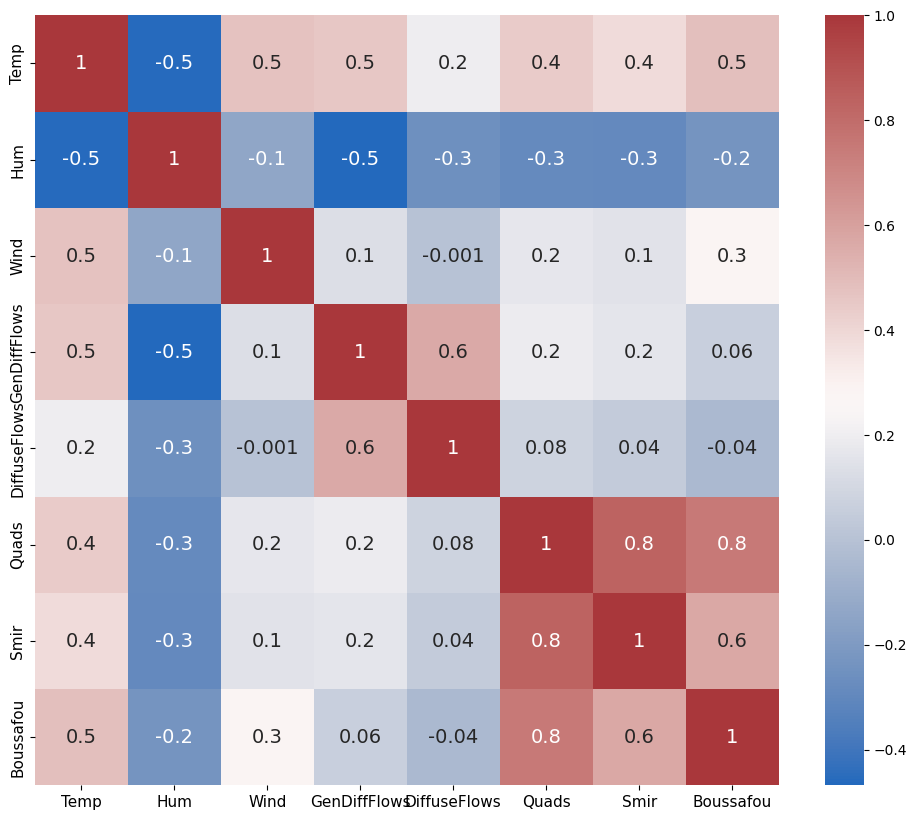

In [ ]:
# Plot correlation matrix
axis_labels = ['Temp', 'Hum', 'Wind', 'GenDiffFlows', 'DiffuseFlows', 'Quads', 'Smir', 'Boussafou']
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap='vlag', fmt='.1g', annot_kws={'fontsize': 14, 'fontweight': 'regular'}, xticklabels=axis_labels, yticklabels=axis_labels)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()


In [ ]:
# zones
zones = ['Quads', 'Smir', 'Boussafou']

# simple moving average (SMA) for each zone
window_sizes = [10, 15, 30]

for zone in zones:
    for window_size in window_sizes:
        df[f'SMA{window_size}_{zone}'] = df[zone].rolling(window=window_size).mean()

df.head()

,Temp,Hum,Wind,GenDiffFlows,DiffuseFlows,Quads,Smir,Boussafou,SMA10_Quads,SMA15_Quads,SMA30_Quads,SMA10_Smir,SMA15_Smir,SMA30_Smir,SMA10_Boussafou,SMA15_Boussafou,SMA30_Boussafou
Datetime,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Percentage of NaN values in each column
nan_percentages = (df.isna().sum() / len(df)) * 100
print(nan_percentages)

Temp               0.000000
Hum                0.000000
Wind               0.000000
GenDiffFlows       0.000000
DiffuseFlows       0.000000
Quads              0.000000
Smir               0.000000
Boussafou          0.000000
SMA10_Quads        0.017170
SMA15_Quads        0.026709
SMA30_Quads        0.055327
SMA10_Smir         0.017170
SMA15_Smir         0.026709
SMA30_Smir         0.055327
SMA10_Boussafou    0.017170
SMA15_Boussafou    0.026709
SMA30_Boussafou    0.055327
dtype: float64


In [ ]:
# Fill NaN values in SMA columns with median
sma_cols = ['SMA10_Quads', 'SMA15_Quads', 'SMA30_Quads', 'SMA10_Smir', 'SMA15_Smir', 'SMA30_Smir', 'SMA10_Boussafou', 'SMA15_Boussafou', 'SMA30_Boussafou']
imputer = SimpleImputer(strategy='median')
df[sma_cols] = imputer.fit_transform(df[sma_cols])

In [ ]:
# Checking for null values
null_counts = df.isnull().sum()
print(null_counts)

Temp               0
Hum                0
Wind               0
GenDiffFlows       0
DiffuseFlows       0
Quads              0
Smir               0
Boussafou          0
SMA10_Quads        0
SMA15_Quads        0
SMA30_Quads        0
SMA10_Smir         0
SMA15_Smir         0
SMA30_Smir         0
SMA10_Boussafou    0
SMA15_Boussafou    0
SMA30_Boussafou    0
dtype: int64


In [ ]:
df.info()

In [ ]:
df.describe().T

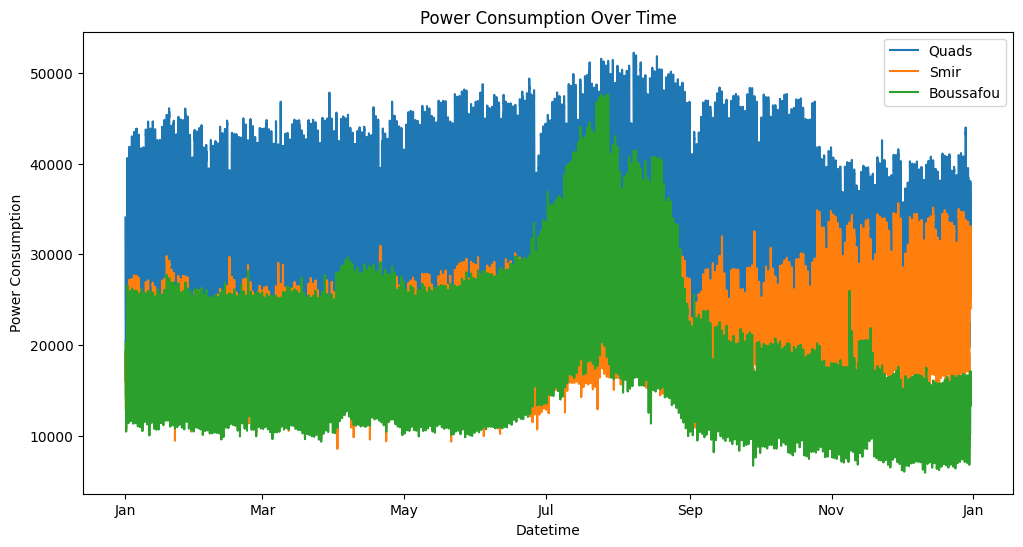

In [ ]:
# Power Consumption Time series
plt.figure(figsize=(12, 6))

[ sns.lineplot(x='Datetime', y=zone, data=df, label=zone) for zone in ['Quads', 'Smir', 'Boussafou'] ]

plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')

# Use DateFormatter to display month labels on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # '%b' for abbreviated month names

plt.show()

In [ ]:
# extracts the hour, day of the week, quarter, month etc. from the datetime index
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)
df.columns

Index(['Temp', 'Hum', 'Wind', 'GenDiffFlows', 'DiffuseFlows', 'Quads', 'Smir',
       'Boussafou', 'SMA10_Quads', 'SMA15_Quads', 'SMA30_Quads', 'SMA10_Smir',
       'SMA15_Smir', 'SMA30_Smir', 'SMA10_Boussafou', 'SMA15_Boussafou',
       'SMA30_Boussafou', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

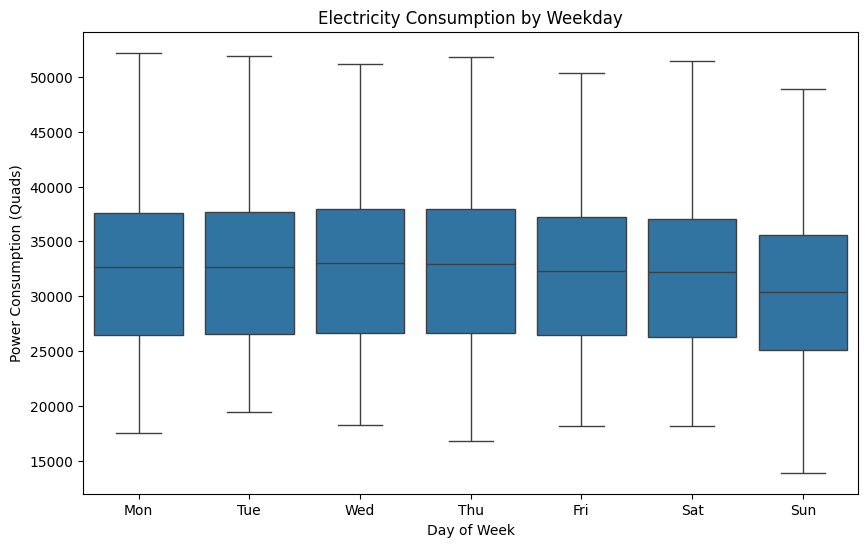

In [ ]:
# weekdays
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10, 6))

sns.boxplot(x='dayofweek', y='Quads', data=df)

# Set the tick labels for the x-axis
plt.xticks(range(7), weekday_order)

# Set the labels and title
plt.xlabel('Day of Week')
plt.ylabel('Power Consumption (Quads)')
plt.title('Electricity Consumption by Weekday')

plt.show()

In [ ]:
# Compute correlation coefficients
correlation = df[['Temp', 'Hum', 'Wind', 'GenDiffFlows', 'DiffuseFlows', 'Quads']].corr()
weather_corr_table = pd.DataFrame({
    'Weather Property': ['Temp', 'Hum', 'Wind', 'GenDiffFlows', 'DiffuseFlows'],
    'Correlation with Power Consumption (Quads)': correlation['Quads'].values[:-1]
})
print(weather_corr_table)

  Weather Property  Correlation with Power Consumption (Quads)
0             Temp                                    0.440221
1              Hum                                   -0.287421
2             Wind                                    0.167444
3     GenDiffFlows                                    0.187965
4     DiffuseFlows                                    0.080274


In [ ]:
# Train and Test Split for all zones
train_start_date = '2017-01-01'
split_date = '2017-10-01'

train = df[df.index < split_date]
test = df[df.index >= split_date]

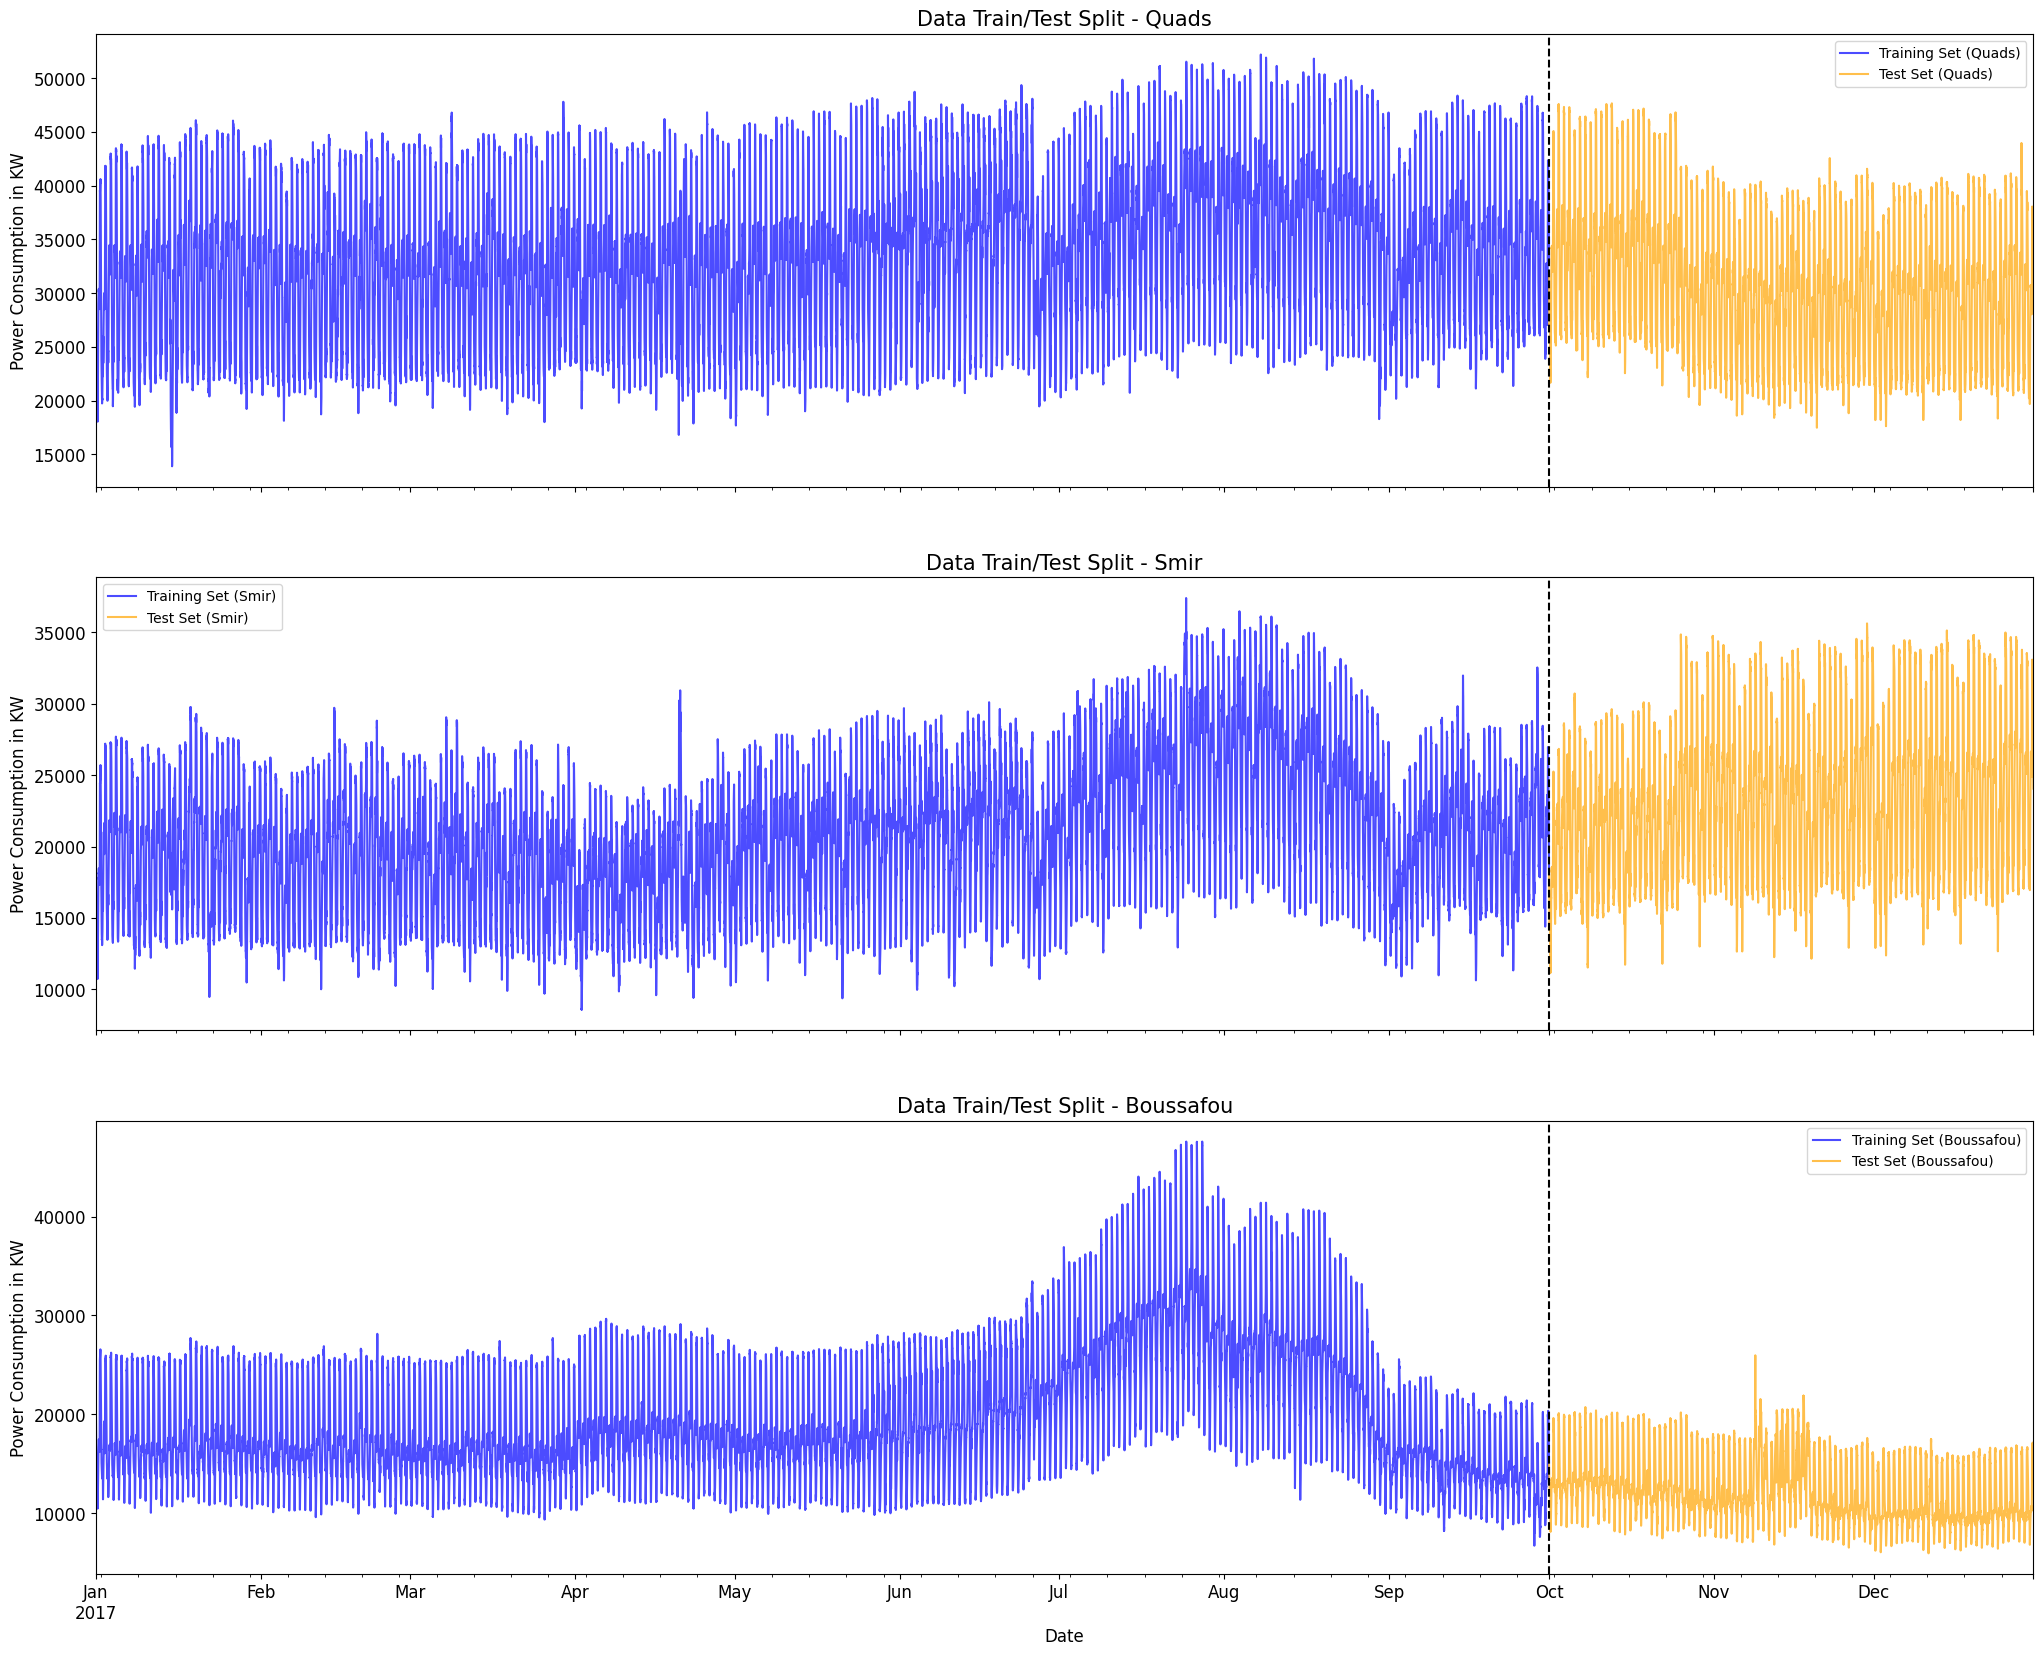

In [ ]:
# Plotting training and test sets for each zone
fig, axs = plt.subplots(3, 1, figsize=(25, 20), sharex=True)

for i, zone in enumerate(['Quads', 'Smir', 'Boussafou']):
    train[zone].plot(ax=axs[i], label=f'Training Set ({zone})', color='blue', alpha=0.7)
    test[zone].plot(ax=axs[i], label=f'Test Set ({zone})', color='orange', alpha=0.7)

    axs[i].axvline(split_date, color='black', ls='--')
    axs[i].legend()

    axs[i].set_title(f'Data Train/Test Split - {zone}', fontsize=15)
    axs[i].set_xlabel('Date', fontsize=12)
    axs[i].set_ylabel('Power Consumption in KW', fontsize=12)
    axs[i].tick_params(labelsize=12)

plt.show()

In [ ]:
# Define input variables and SMA columns for each model
shared_vars = ['Temp', 'Hum', 'Wind', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

In [ ]:
model_config = {
    'xgb': {
        'input_vars': ['Temp', 'hour', 'dayofweek', 'quarter', 'month', 'dayofyear'],
        'sma_cols': {
            'Quads': ['SMA10_Quads', 'SMA15_Quads', 'SMA30_Quads'],
            'Smir': ['SMA10_Smir', 'SMA15_Smir', 'SMA30_Smir'],
            'Boussafou': ['SMA10_Boussafou', 'SMA15_Boussafou', 'SMA30_Boussafou']
        }
    },
    'rf': {
        'input_vars': ['Temp','hour', 'dayofyear'],
        'sma_cols': {
            'Quads': ['SMA10_Quads', 'SMA15_Quads', 'SMA30_Quads'],
            'Smir': ['SMA10_Smir', 'SMA15_Smir', 'SMA30_Smir'],
            'Boussafou': ['SMA10_Boussafou', 'SMA15_Boussafou', 'SMA30_Boussafou']
        }
    },
    'ffnn': {
        'input_vars': ['Temp', 'Hum', 'Wind', 'hour', 'dayofweek', 'quarter', 'month', 'dayofyear'],
        'sma_cols': {
            'Quads': ['SMA10_Quads', 'SMA15_Quads', 'SMA30_Quads'],
            'Smir': ['SMA10_Smir', 'SMA15_Smir', 'SMA30_Smir'],
            'Boussafou': ['SMA10_Boussafou', 'SMA15_Boussafou', 'SMA30_Boussafou']
        }
    }
}

In [ ]:
def split_data(df, model_name, train_end_date='2017-10-01'):
    model_info = model_config[model_name]
    input_vars = model_info['input_vars']
    sma_cols = model_info['sma_cols']

    # Min-Max scaling
    scaler = MinMaxScaler()
    df[input_vars] = scaler.fit_transform(df[input_vars])

    # Split data into train and test sets
    train = df.loc[:train_end_date]
    test = df.loc[train_end_date:]

    # Prepare input and target variables for each zone
    X_train, y_train, X_test, y_test = {}, {}, {}, {}

    for zone, sma_columns in sma_cols.items():
        # Concatenate shared variables with SMA columns
        X_train[zone] = pd.concat([train[shared_vars], train[sma_columns].add_prefix(f"{zone}_")], axis=1)
        y_train[zone] = train[zone]
        X_test[zone] = pd.concat([test[shared_vars], test[sma_columns].add_prefix(f"{zone}_")], axis=1)
        y_test[zone] = test[zone]


        # # Print X_train and y_train for each zone
        # print(f"X_train[{zone}]:")
        # print(X_train[zone].head())
        # print("\n")
        # print(f"y_train[{zone}]:")
        # print(y_train[zone].head())
        # print("\n")

    return X_train, y_train, X_test, y_test

In [ ]:
# Function to train XGBoost models for a specific model
def train_xgboost_models(df, model_name, train_end_date='2017-10-01'):

    # Split the data for the specific model
    X_train, y_train, X_test, y_test = split_data(df, model_name, train_end_date)

    # Model parameters
    reg_params = {
        'base_score': 0.5,
        'booster': 'gbtree',
        'n_estimators': 1500,
        'objective': 'reg:squarederror',
        'max_depth': 3,
        'learning_rate': 0.3,
        'random_state': 48
    }

    # Train XGBoost models
    models = {}
    for zone in y_train.keys():
        print(f"Fitting XGBoost model for zone: {zone}")
        reg = xgb.XGBRegressor(**reg_params)
        reg.fit(X_train[zone], y_train[zone],
                eval_set=[(X_train[zone], y_train[zone]), (X_test[zone], y_test[zone])],
                verbose=100)
        models[zone] = reg

    return models

In [ ]:
# Function to train Random Forest models for a specific model
def train_random_forest_models(df, model_name, train_end_date='2017-10-01'):

    # Split the data for the specific model
    X_train, y_train, X_test, y_test = split_data(df, model_name, train_end_date)

    # Train Random Forest models
    rf_models = {}
    for zone in y_train.keys():
        print(f"Fitting Random Forest model for zone: {zone}")
        rf_reg = RandomForestRegressor(n_estimators=50, min_samples_split=2, max_depth=None, min_samples_leaf=10, random_state=42)
        rf_reg.fit(X_train[zone], y_train[zone])
        rf_models[zone] = rf_reg

    return rf_models


In [ ]:
# Function to train FFNN models for a specific model
def train_ffnn_models(df, model_name, train_end_date='2017-10-01'):

    # Split the data for the specific model
    X_train, y_train, X_test, y_test = split_data(df, model_name, train_end_date)

    # Train FFNN models
    ffnn_models = {}
    for zone in y_train.keys():
        print(f"Fitting FFNN model for zone: {zone}")

        # input layer with input shape
        input_layer = Input(shape=(X_train[zone].shape[1],))

        # Create FFNN model using Functional API
        x = Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
        output_layer = Dense(1)(x)

        # Define the model
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Changed optimizer to Adam
        model.compile(optimizer=optimizer, loss='mse')

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

        # Train
        history = model.fit(X_train[zone], y_train[zone], epochs=10, batch_size=64,  # Increased epochs, reduced batch size
                            validation_data=(X_test[zone], y_test[zone]), verbose=1,
                            callbacks=[early_stopping, reduce_lr])

        # Store model
        ffnn_models[zone] = model

    return ffnn_models

In [ ]:
def evaluate_models(models, X_test, y_test, model_name):
    """
    Evaluate trained models.
    """
    for zone, model in models.items():
        print(f"Evaluation results for model: {model_name} - {zone}")
        if isinstance(model, dict):
            model = model['model']  # Access the model from the dictionary
        X_test_model = X_test[zone]  # Get the test data for the specific zone
        y_test_model = y_test[zone]
        y_pred = model.predict(X_test_model)
        print("Explained Variance Score:", explained_variance_score(y_test_model, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_test_model, y_pred))
        print("Mean Squared Error:", mean_squared_error(y_test_model, y_pred))
        print("Median Absolute Error:", median_absolute_error(y_test_model, y_pred))
        print("R-squared:", r2_score(y_test_model, y_pred))
        print("\n")


In [ ]:
def plot_feature_importance(models, X_train):
    """
    Plot feature importance for Random Forest models.
    """
    for model_name, model in models.items():
        if isinstance(model, dict):
            # For XGBoost and Random Forest models
            model = model['model']
        elif isinstance(model, Sequential):
            # For FFNN models
            model = model

        if hasattr(model, 'feature_importances_'):
            # For XGBoost and Random Forest models
            feature_importance = model.feature_importances_
        elif hasattr(model, 'get_weights'):
            # For FFNN models
            weights = model.get_weights()
            feature_importance = np.mean(np.abs(weights[0]), axis=1)
        else:
            print(f"Model {model_name} does not have feature importance information.")
            continue

        X_train_model = X_train[model_name]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance, y=X_train_model.columns)
        plt.title(f'Feature Importance for Model: {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()


In [ ]:
# DEBUG

# print("Columns in train DataFrame:")
# print(train.columns)

# print("\nColumns in test DataFrame:")
# print(test.columns)


In [ ]:
xgb_models = train_xgboost_models(df, 'xgb')

Fitting XGBoost model for zone: Quads
[0]	validation_0-rmse:23719.83652	validation_1-rmse:21613.32555
[100]	validation_0-rmse:868.71497	validation_1-rmse:1794.33489
[200]	validation_0-rmse:769.70190	validation_1-rmse:1674.62236
[300]	validation_0-rmse:718.05823	validation_1-rmse:1643.63253
[400]	validation_0-rmse:680.41755	validation_1-rmse:1591.81219
[500]	validation_0-rmse:654.00777	validation_1-rmse:1499.59196
[600]	validation_0-rmse:631.85889	validation_1-rmse:1470.66177
[700]	validation_0-rmse:613.13723	validation_1-rmse:1435.73736
[800]	validation_0-rmse:596.51075	validation_1-rmse:1430.74144
[900]	validation_0-rmse:582.85227	validation_1-rmse:1422.20005
[1000]	validation_0-rmse:571.66638	validation_1-rmse:1420.69452
[1100]	validation_0-rmse:560.10890	validation_1-rmse:1417.89452
[1200]	validation_0-rmse:550.21505	validation_1-rmse:1414.00410
[1300]	validation_0-rmse:541.81118	validation_1-rmse:1417.35707
[1400]	validation_0-rmse:532.79675	validation_1-rmse:1414.20195
[1499]	vali

In [ ]:
# Train Random Forest models
rf_models = train_random_forest_models(df, 'rf')

Fitting Random Forest model for zone: Quads
Fitting Random Forest model for zone: Smir
Fitting Random Forest model for zone: Boussafou


In [ ]:
# Train FFNN models
ffnn_models = train_ffnn_models(df, 'ffnn')

Fitting FFNN model for zone: Quads
Epoch 1/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 210850976.0000 - val_loss: 15048683.0000 - learning_rate: 0.0010
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19295410.0000 - val_loss: 12926810.0000 - learning_rate: 0.0010
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16511419.0000 - val_loss: 10413737.0000 - learning_rate: 0.0010
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12993541.0000 - val_loss: 7745729.0000 - learning_rate: 0.0010
Epoch 5/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9179031.0000 - val_loss: 3022871.5000 - learning_rate: 0.0010
Epoch 6/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3829798.2500 - val_loss: 2392982.7500 - learning_rate: 0.0010
Epoch 7/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3247702.5000 - val_loss: 2394832.0000 - learning_rate: 0.0010
Epoch 8/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2977925.7500 - val_loss: 2155552.2500 - lea

In [ ]:
# DEBUG
# # Function to check for NaN values in predictions
# def check_nan_predictions(models, X_test):
#     for zone, model in models.items():
#         print(f"Checking for NaN values in predictions for zone: {zone}")
#         X_test_zone = X_test[zone]
#         predictions = model.predict(X_test_zone)
#         nan_count = np.sum(np.isnan(predictions))
#         if nan_count > 0:
#             print(f"NaN values found in predictions for zone: {zone}, count: {nan_count}")
#         else:
#             print(f"No NaN values found in predictions for zone: {zone}")

# # Check for NaN values in predictions
# check_nan_predictions(ffnn_models, X_test_ffnn)

In [ ]:
# Split the data
X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb = split_data(df, 'xgb')

# DEBUG


# # Convert train and test data to DataFrames for XGBoost
# df_X_train_xgb = pd.concat([pd.DataFrame(X_train_xgb[zone]).add_prefix(f"{zone}_") for zone in X_train_xgb.keys()], axis=1)
# df_y_train_xgb = pd.concat([pd.DataFrame(y_train_xgb[zone], columns=[zone]) for zone in y_train_xgb.keys()], axis=1)
# df_X_test_xgb = pd.concat([pd.DataFrame(X_test_xgb[zone]).add_prefix(f"{zone}_") for zone in X_test_xgb.keys()], axis=1)
# df_y_test_xgb = pd.concat([pd.DataFrame(y_test_xgb[zone], columns=[zone]) for zone in y_test_xgb.keys()], axis=1)

# # Print the DataFrames
# print("X_train_xgb DataFrame:")
# print(df_X_train_xgb)
# print("\n")
# print("y_train_xgb DataFrame:")
# print(df_y_train_xgb)
# print("\n")
# print("X_test_xgb DataFrame:")
# print(df_X_test_xgb)
# print("\n")
# print("y_test_xgb DataFrame:")
# print(df_y_test_xgb)

# Evaluate XGBoost models
evaluate_models(xgb_models, X_test_xgb, y_test_xgb, 'xgb')

Evaluation results for model: xgb - Quads
Explained Variance Score: 0.9331678477121417
Mean Absolute Error: 1235.5664136863745
Mean Squared Error: 2819194.5738615063
Median Absolute Error: 894.9138174999989
R-squared: 0.9323569200117197


Evaluation results for model: xgb - Smir
Explained Variance Score: 0.9610790436618499
Mean Absolute Error: 800.9050608612829
Mean Squared Error: 1190641.6606121827
Median Absolute Error: 604.1309771874985
R-squared: 0.9584541782907192


Evaluation results for model: xgb - Boussafou
Explained Variance Score: 0.832850492716387
Mean Absolute Error: 1099.5646390385593
Mean Squared Error: 2038516.980224481
Median Absolute Error: 859.7530045312496
R-squared: 0.813538775038646




In [ ]:
# Split the data
X_train_rf, y_train_rf, X_test_rf, y_test_rf = split_data(df, 'rf')


# # Print train and test values for Random Forest
# print("X_train_rf:", X_train_rf)
# print("y_train_rf:", y_train_rf)
# print("X_test_rf:", X_test_rf)
# print("y_test_rf:", y_test_rf)

# Evaluate Random Forest models
evaluate_models(rf_models, X_test_rf, y_test_rf, 'rf')


Evaluation results for model: rf - Quads
Explained Variance Score: 0.9287191089189978
Mean Absolute Error: 1105.5683229931592
Mean Squared Error: 3295885.1317978953
Median Absolute Error: 535.2416766984497
R-squared: 0.9209193208338867


Evaluation results for model: rf - Smir
Explained Variance Score: 0.9709732701092473
Mean Absolute Error: 604.4790487755887
Mean Squared Error: 836510.9398494592
Median Absolute Error: 387.8042458887194
R-squared: 0.9708110882438133


Evaluation results for model: rf - Boussafou
Explained Variance Score: 0.8881235563733345
Mean Absolute Error: 837.688535147626
Mean Squared Error: 1368273.0156102
Median Absolute Error: 573.2663799377915
R-squared: 0.8748453581465145




In [ ]:
# Split the data
X_train_ffnn, y_train_ffnn, X_test_ffnn, y_test_ffnn = split_data(df, 'ffnn')

# Convert train and test data to DataFrames for FFNN
df_X_train_ffnn = pd.concat([pd.DataFrame(X_train_ffnn[zone]).add_prefix(f"{zone}_") for zone in X_train_ffnn.keys()], axis=1)
df_y_train_ffnn = pd.concat([pd.DataFrame(y_train_ffnn[zone], columns=[zone]) for zone in y_train_ffnn.keys()], axis=1)
# df_X_test_ffnn = pd.concat([pd.DataFrame(X_test_ffnn[zone]).add_prefix(f"{zone}_") for zone in X_test_ffnn.keys()], axis=1)
# df_y_test_ffnn = pd.concat([pd.DataFrame(y_test_ffnn[zone], columns=[zone]) for zone in y_test_ffnn.keys()], axis=1)

# DEBUG
# Print the DataFrames
print("X_train_ffnn DataFrame:")
print(df_X_train_ffnn.columns)
print("\n")
print("y_train_ffnn DataFrame:")
print(df_y_train_ffnn.columns)
print("\n")
# print("X_test_ffnn DataFrame:")
# print(df_X_test_ffnn)
# print("\n")
# print("y_test_ffnn DataFrame:")
# print(df_y_test_ffnn)
# print("\n")

# # Evaluate FFNN models
# evaluate_models(ffnn_models, X_test_ffnn, y_test_ffnn, 'ffnn')


X_train_ffnn DataFrame:
Index(['Quads_Temp', 'Quads_Hum', 'Quads_Wind', 'Quads_hour',
       'Quads_dayofweek', 'Quads_quarter', 'Quads_month', 'Quads_year',
       'Quads_dayofyear', 'Quads_Quads_SMA10_Quads', 'Quads_Quads_SMA15_Quads',
       'Quads_Quads_SMA30_Quads', 'Smir_Temp', 'Smir_Hum', 'Smir_Wind',
       'Smir_hour', 'Smir_dayofweek', 'Smir_quarter', 'Smir_month',
       'Smir_year', 'Smir_dayofyear', 'Smir_Smir_SMA10_Smir',
       'Smir_Smir_SMA15_Smir', 'Smir_Smir_SMA30_Smir', 'Boussafou_Temp',
       'Boussafou_Hum', 'Boussafou_Wind', 'Boussafou_hour',
       'Boussafou_dayofweek', 'Boussafou_quarter', 'Boussafou_month',
       'Boussafou_year', 'Boussafou_dayofyear',
       'Boussafou_Boussafou_SMA10_Boussafou',
       'Boussafou_Boussafou_SMA15_Boussafou',
       'Boussafou_Boussafou_SMA30_Boussafou'],
      dtype='object')


y_train_ffnn DataFrame:
Index(['Quads', 'Smir', 'Boussafou'], dtype='object')




In [ ]:
# # Check for NaN and missing values in train and test DataFrames for FFNN
# nan_counts_X_train_ffnn = df_X_train_ffnn.isnull().sum()
# nan_counts_y_train_ffnn = df_y_train_ffnn.isnull().sum()
# nan_counts_X_test_ffnn = df_X_test_ffnn.isnull().sum()
# nan_counts_y_test_ffnn = df_y_test_ffnn.isnull().sum()

# # Print NaN counts
# print("NaN counts in X_train_ffnn:")
# print(nan_counts_X_train_ffnn)
# print("\n")

# print("NaN counts in y_train_ffnn:")
# print(nan_counts_y_train_ffnn)
# print("\n")

# print("NaN counts in X_test_ffnn:")
# print(nan_counts_X_test_ffnn)
# print("\n")

# print("NaN counts in y_test_ffnn:")
# print(nan_counts_y_test_ffnn)
# print("\n")


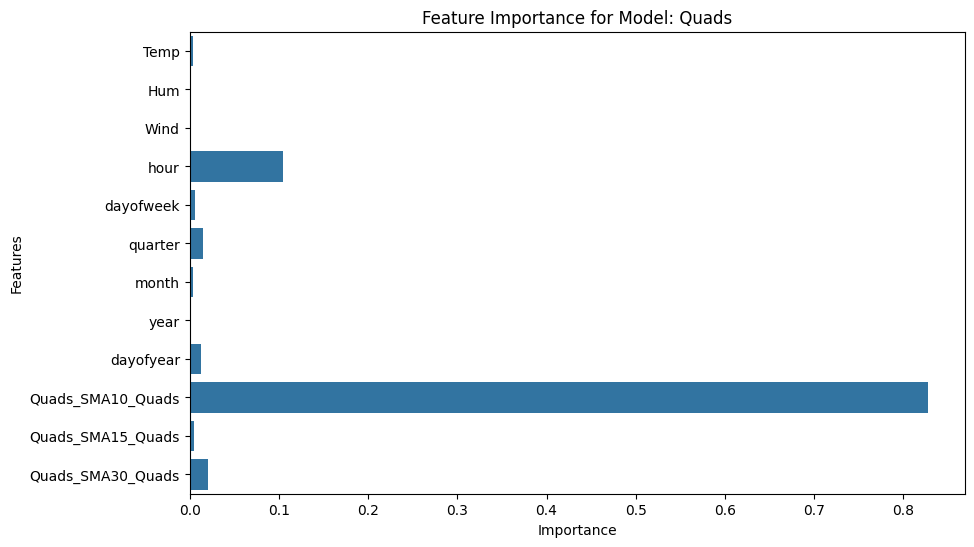

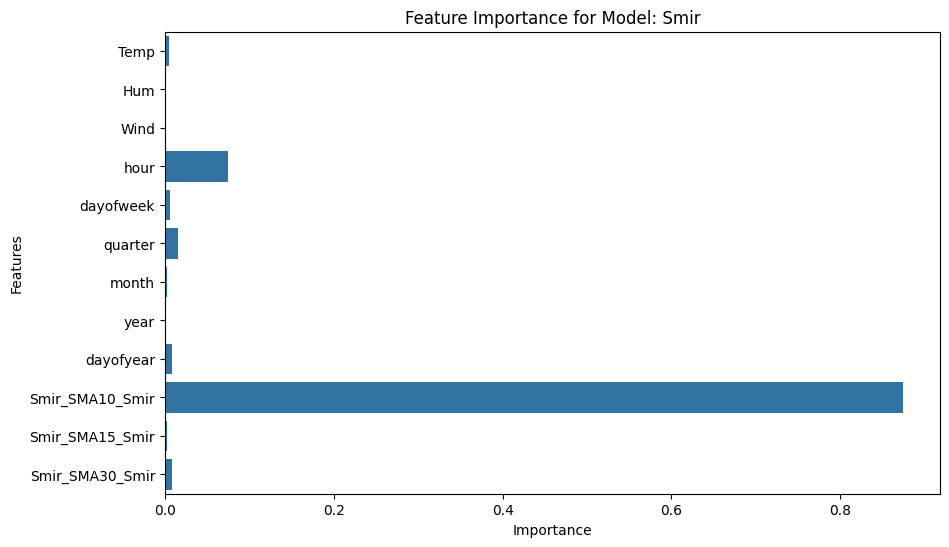

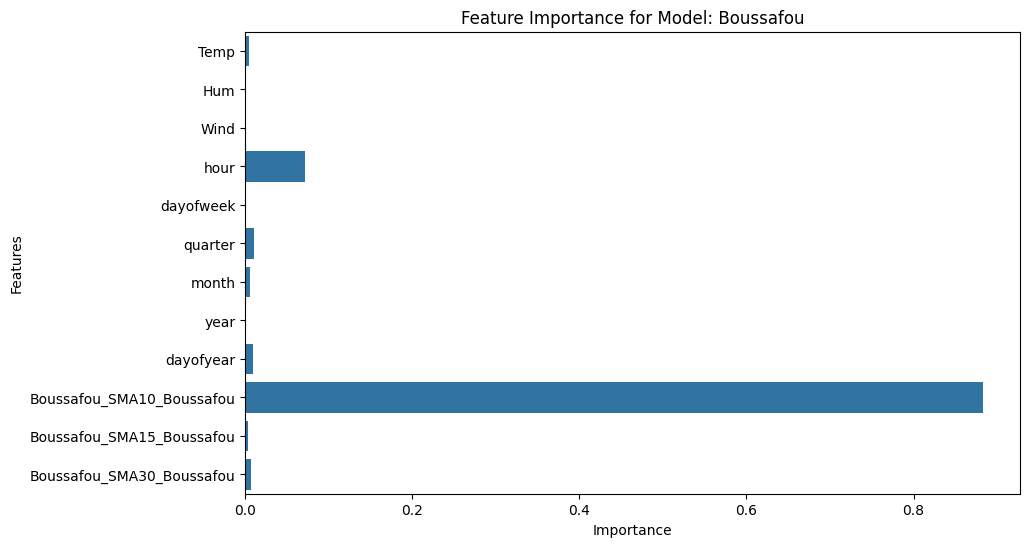

In [ ]:
# Call the function with your trained models and training data
plot_feature_importance(xgb_models, X_train_xgb)

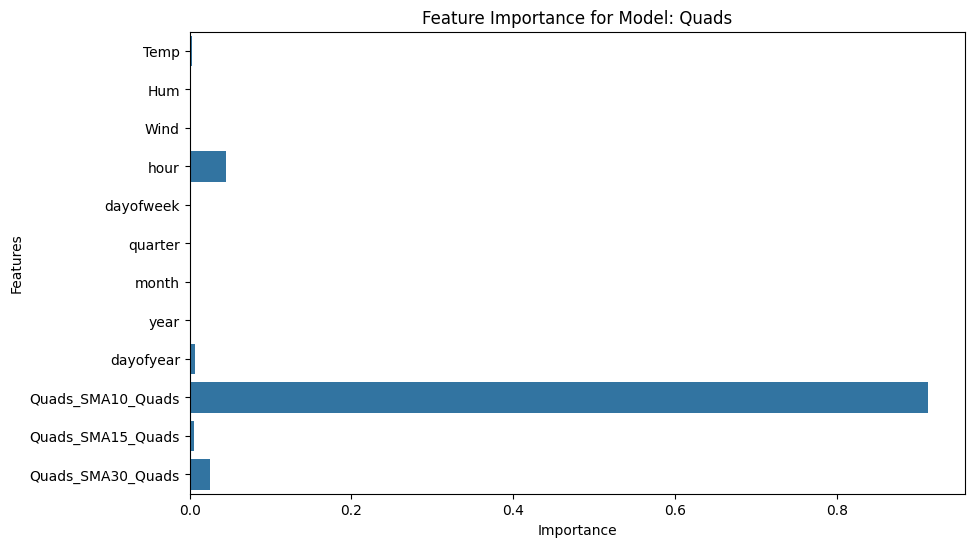

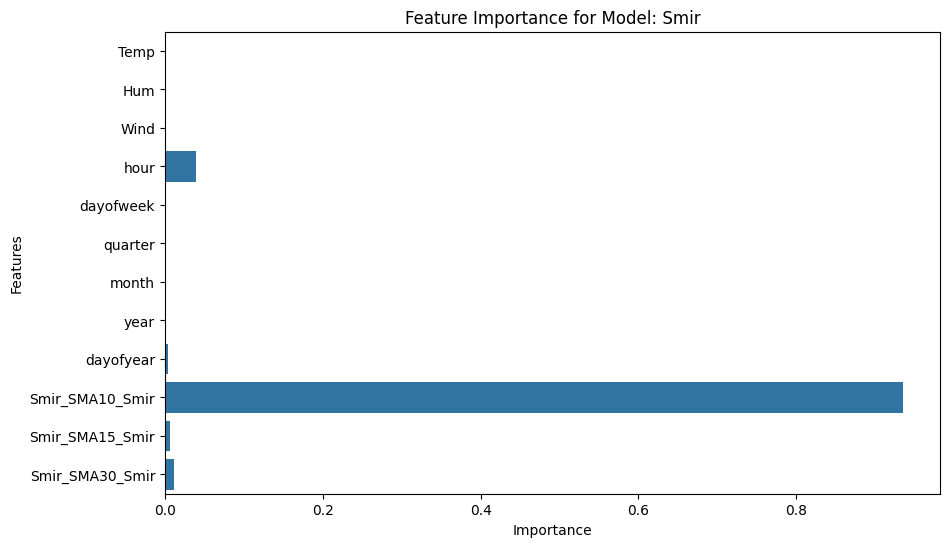

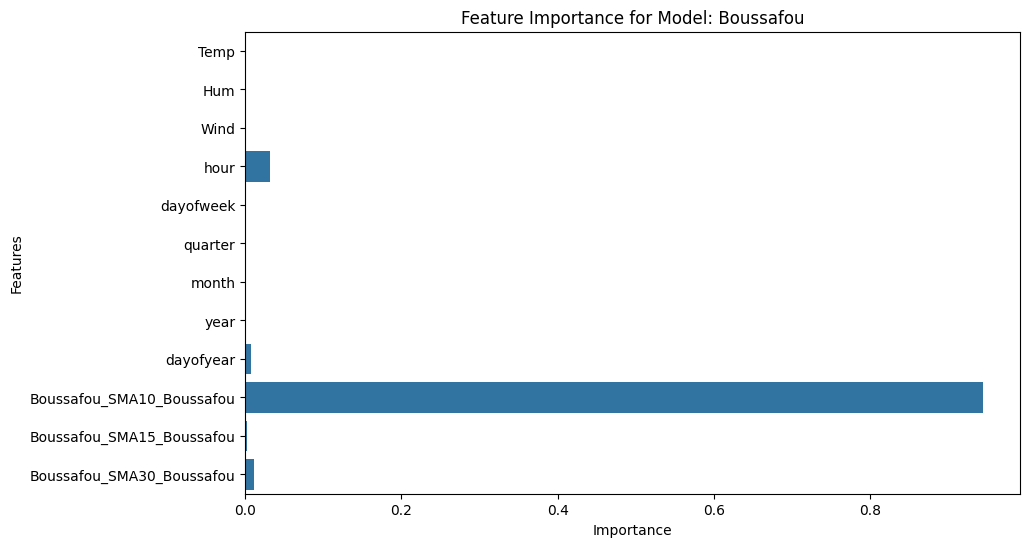

In [ ]:
plot_feature_importance(rf_models, X_train_rf)

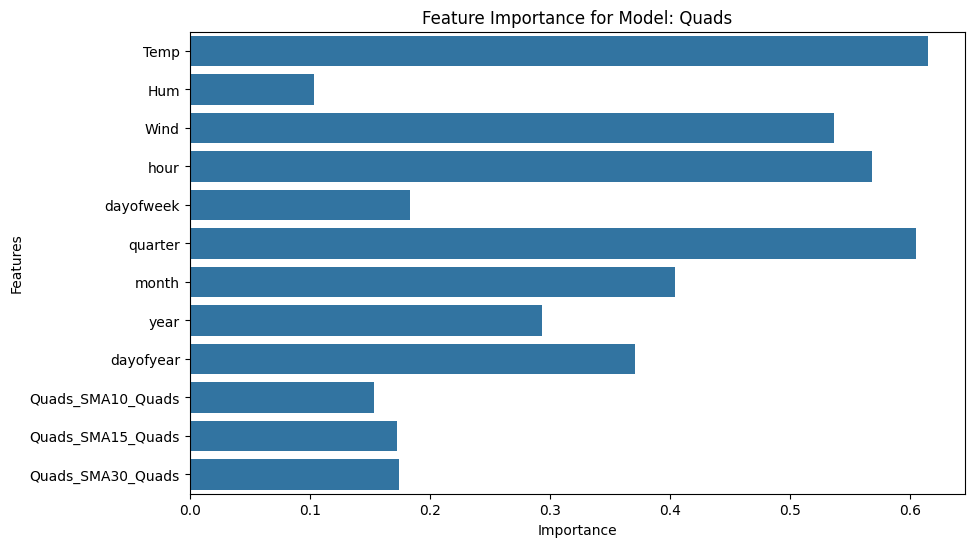

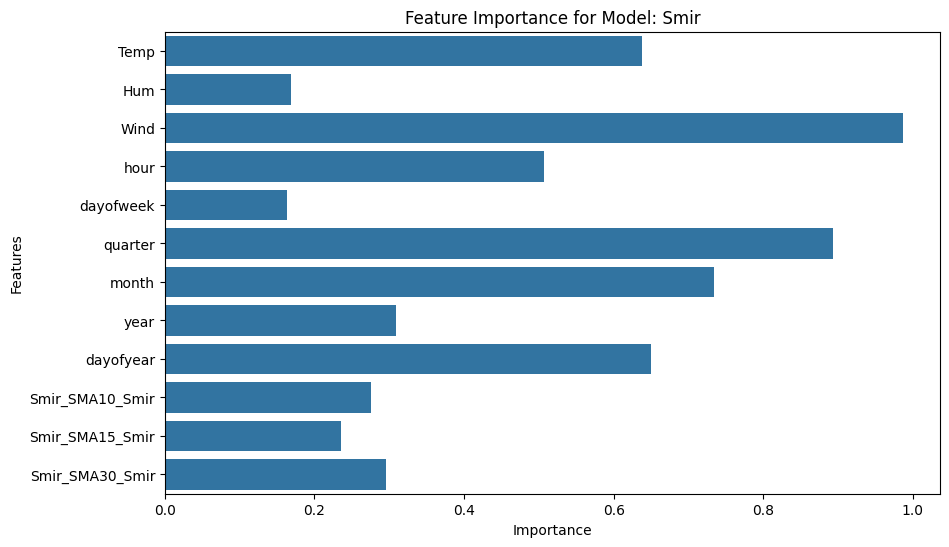

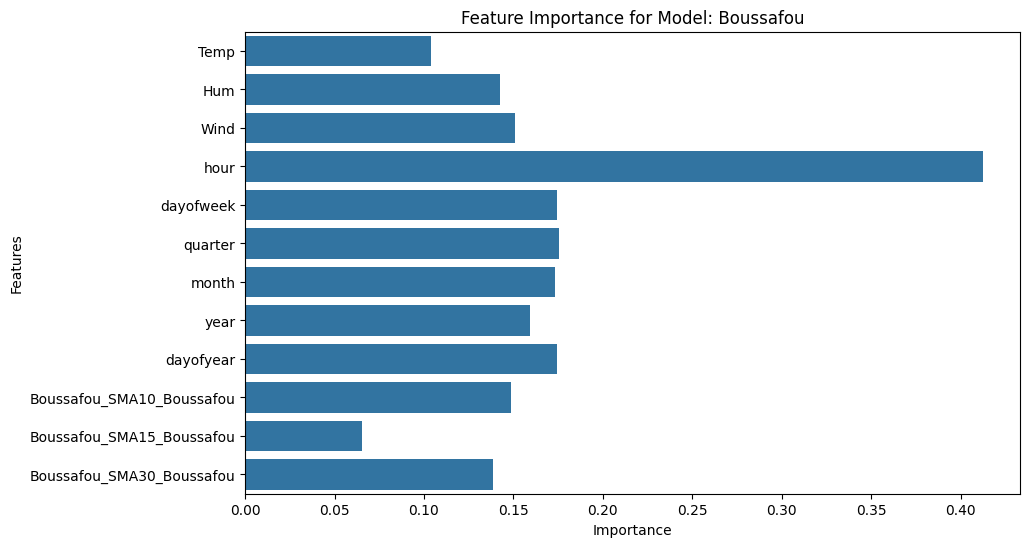

In [ ]:
plot_feature_importance(ffnn_models, X_train_ffnn)

In [ ]:
# Iterate over each zone
for zone in zones:
    # Make predictions for the current zone
    y_pred = ffnn_models[zone].predict(X_test_ffnn[zone])

    # Create a DataFrame for predictions
    y_pred_df = pd.DataFrame({f'prediction_{zone}': y_pred.flatten()}, index=X_test_ffnn[zone].index)

    # Merge predictions with the original dataset
    df = df.merge(y_pred_df, how='left', left_index=True, right_index=True)

410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


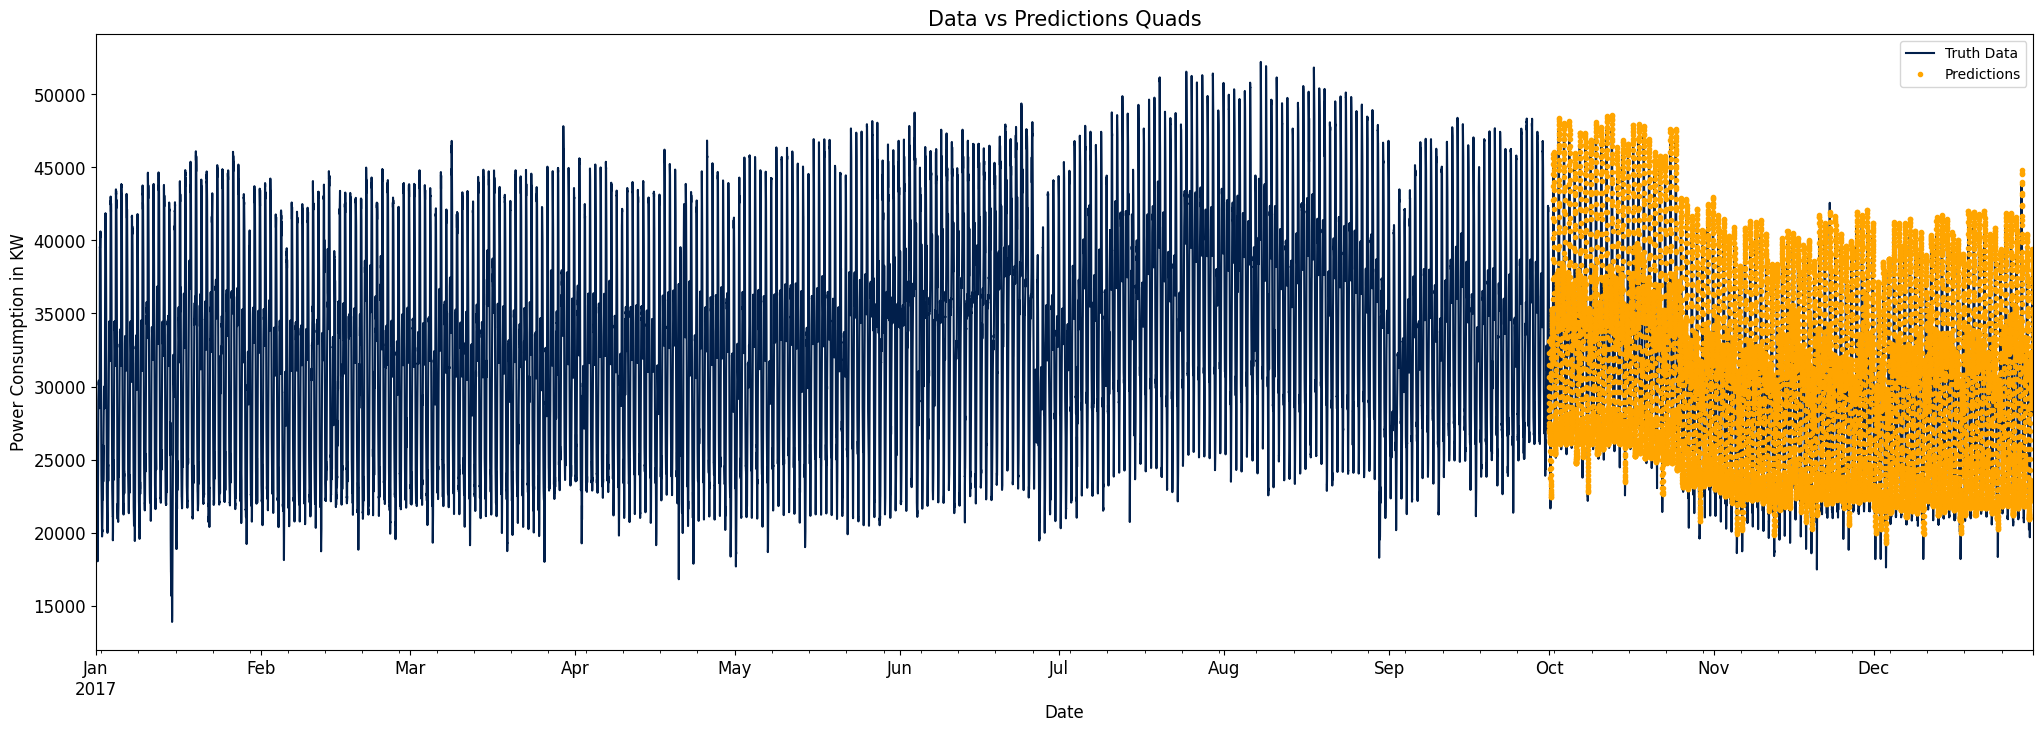

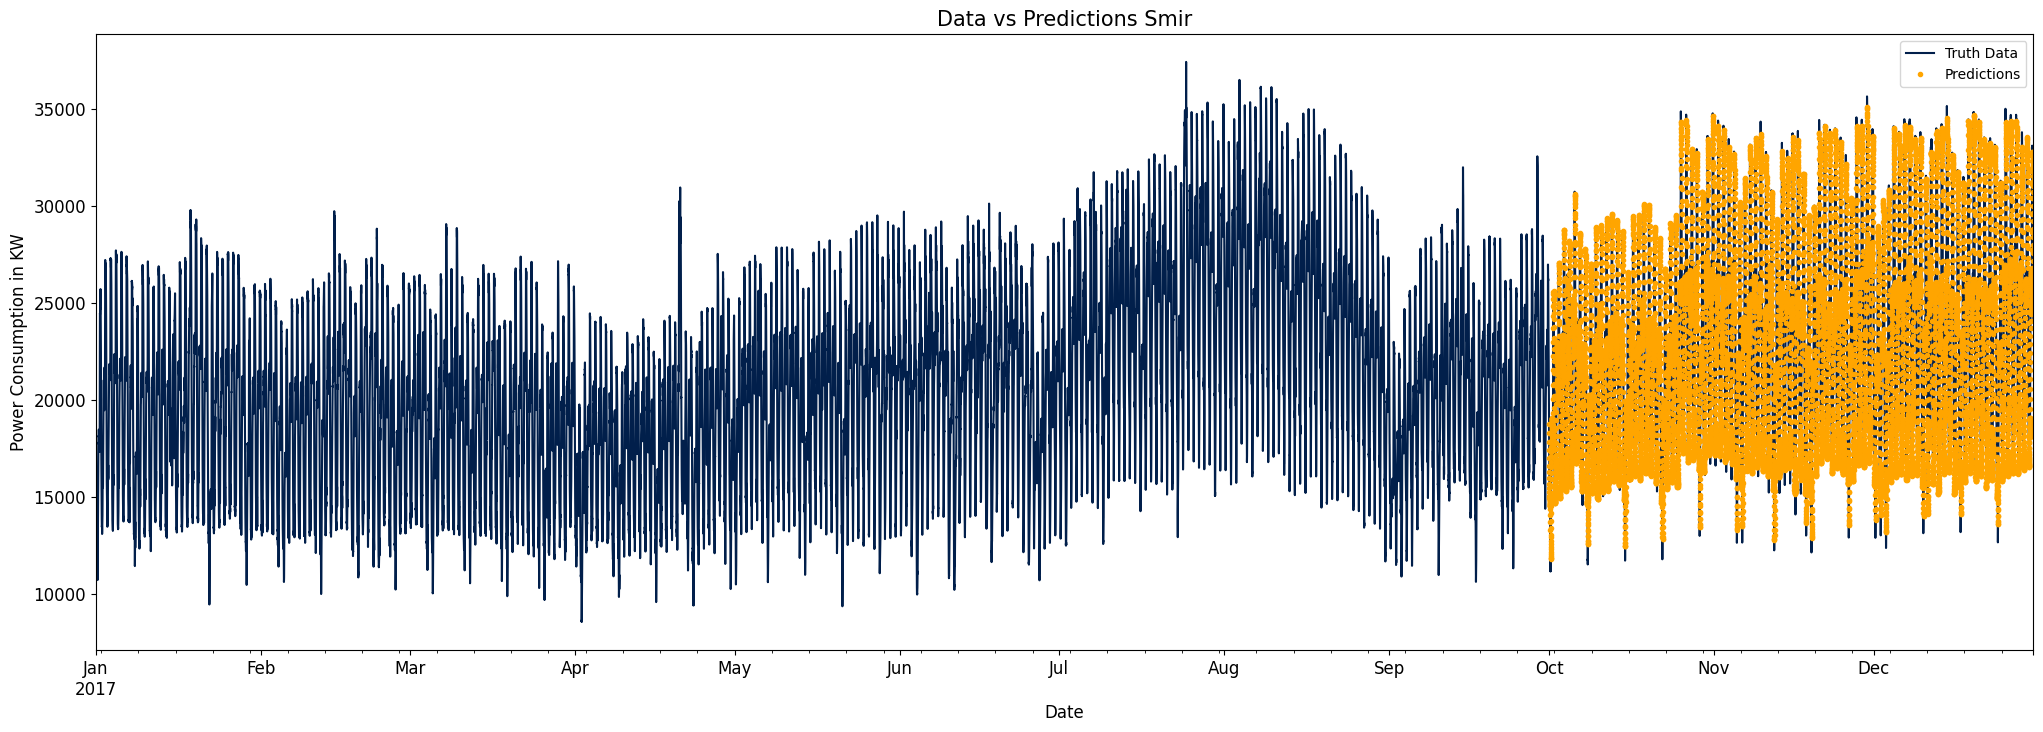

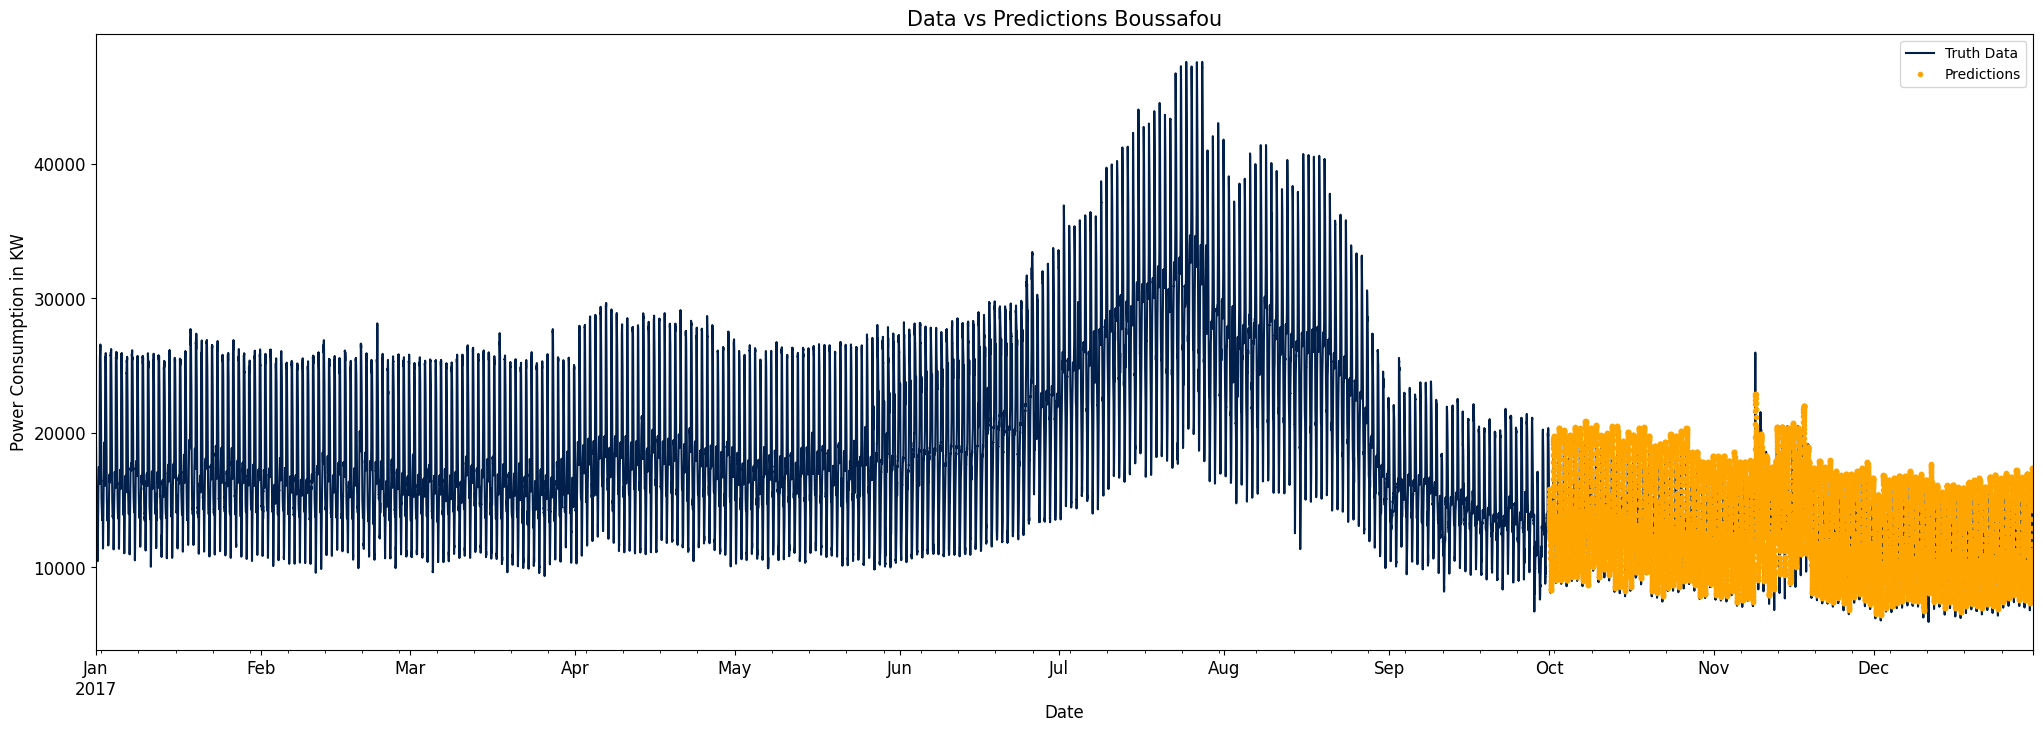

In [ ]:
# Plot predictions for each zone
for zone in zones:
    # Plot actual data vs predictions for the current zone
    ax = df[[zone]].plot(figsize=(25, 8), color="#011f4b")
    df[f'prediction_{zone}'].plot(ax=ax, style='.', color="orange")

    plt.legend(['Truth Data', 'Predictions'])

    plt.title(f'Data vs Predictions {zone}', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Power Consumption in KW', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

In [ ]:
# DEBUG
# print(df.columns)

Index(['Temp', 'Hum', 'Wind', 'GenDiffFlows', 'DiffuseFlows', 'Quads', 'Smir',
       'Boussafou', 'SMA10_Quads', 'SMA15_Quads', 'SMA30_Quads', 'SMA10_Smir',
       'SMA15_Smir', 'SMA30_Smir', 'SMA10_Boussafou', 'SMA15_Boussafou',
       'SMA30_Boussafou', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'prediction_Quads',
       'prediction_Smir', 'prediction_Boussafou'],
      dtype='object')


In [ ]:
# DEBUG
# print(df.loc[(df.index > '2017-10-01') & (df.index < '2017-10-15')].head())

                         Temp       Hum      Wind  GenDiffFlows  DiffuseFlows  \
Datetime                                                                        
2017-10-01 00:10:00  0.401300  0.924515  0.756412         0.055         0.137   
2017-10-01 00:20:00  0.401572  0.923317  0.756412         0.069         0.148   
2017-10-01 00:30:00  0.405652  0.923317  0.756101         0.062         0.167   
2017-10-01 00:40:00  0.406196  0.931704  0.756568         0.051         0.115   
2017-10-01 00:50:00  0.409189  0.930506  0.756879         0.062         0.133   

                           Quads         Smir    Boussafou   SMA10_Quads  \
Datetime                                                                   
2017-10-01 00:10:00  31175.84245  17611.61826  14531.30699  34494.208554   
2017-10-01 00:20:00  30154.92341  17148.54772  14321.21581  33719.187621   
2017-10-01 00:30:00  29764.20131  16827.38589  14198.66261  32977.094478   
2017-10-01 00:40:00  29600.35011  16621.99170  13889

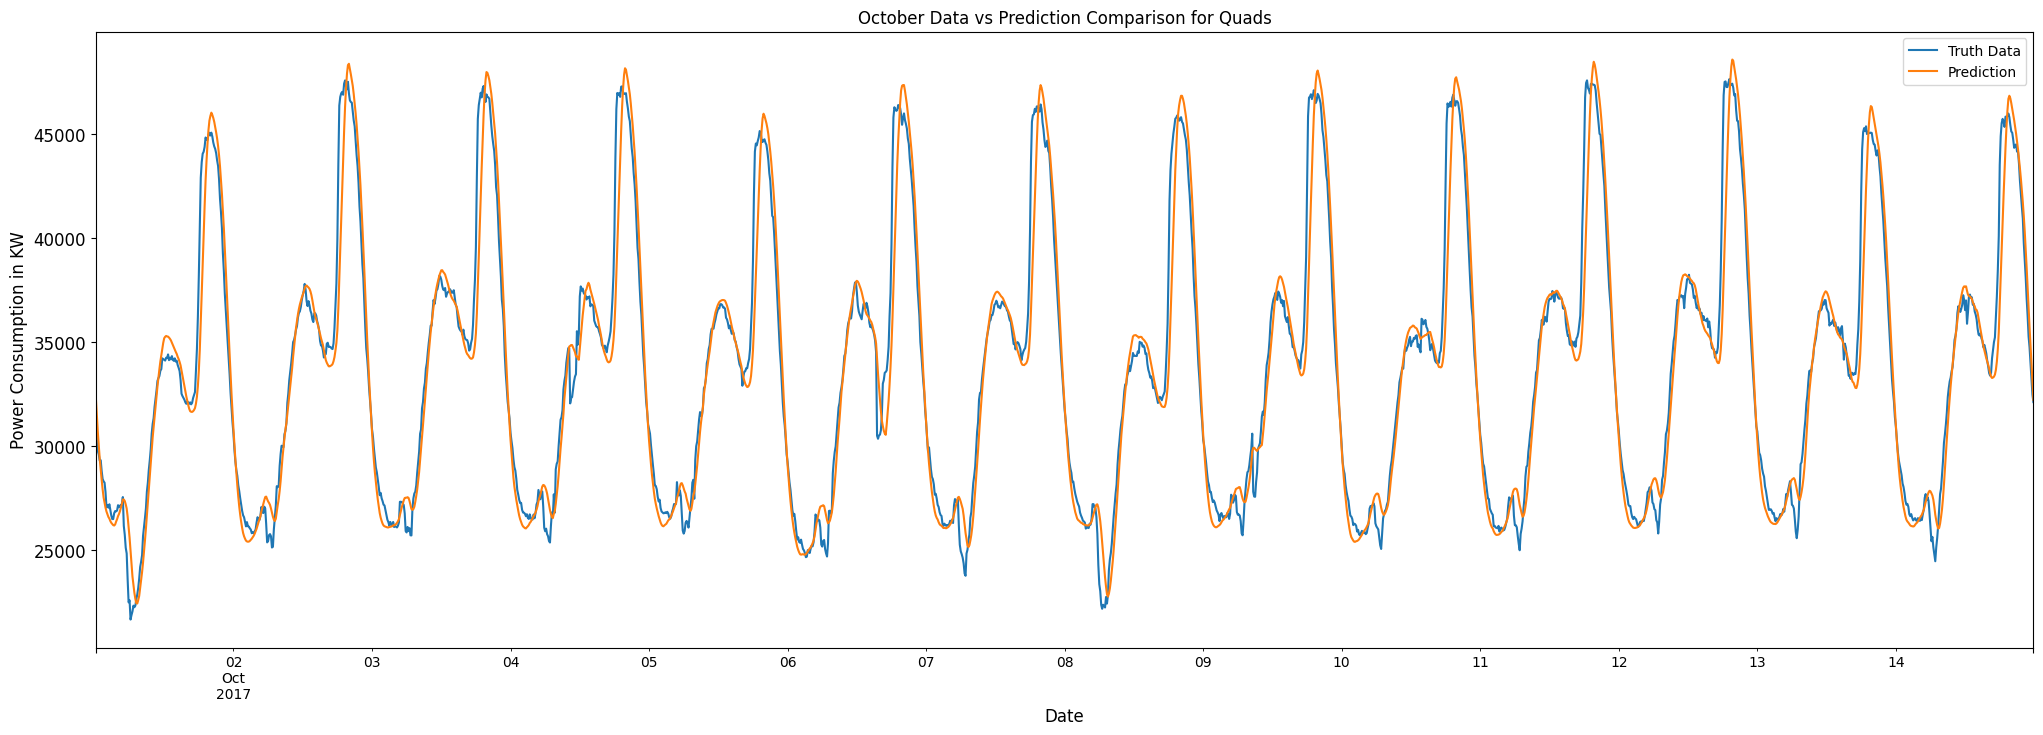

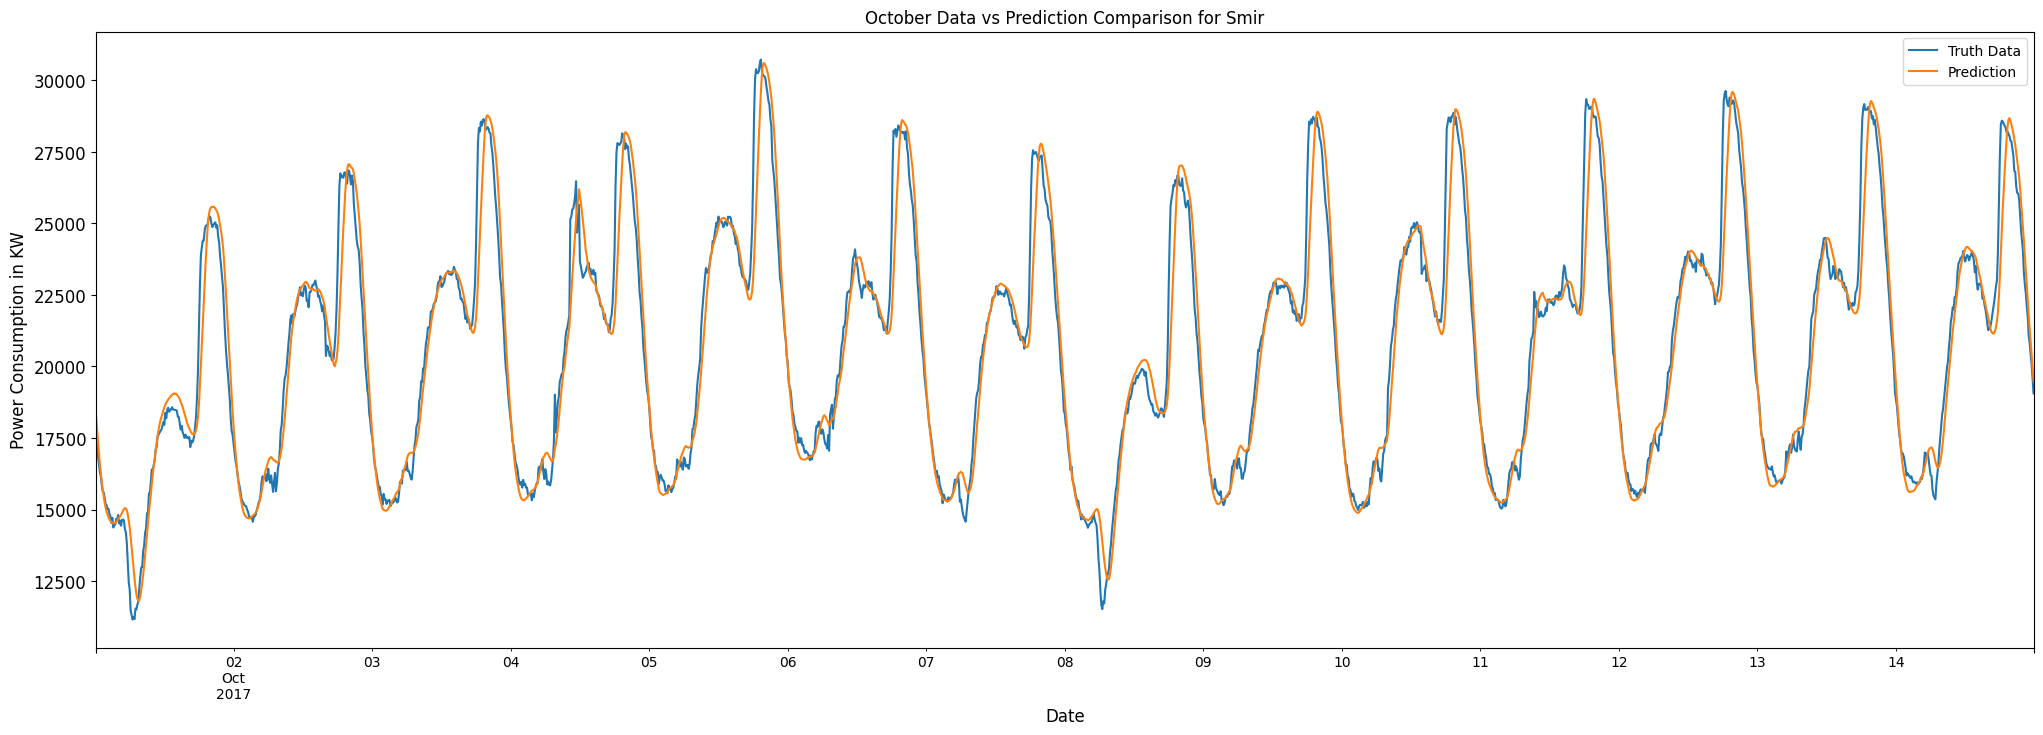

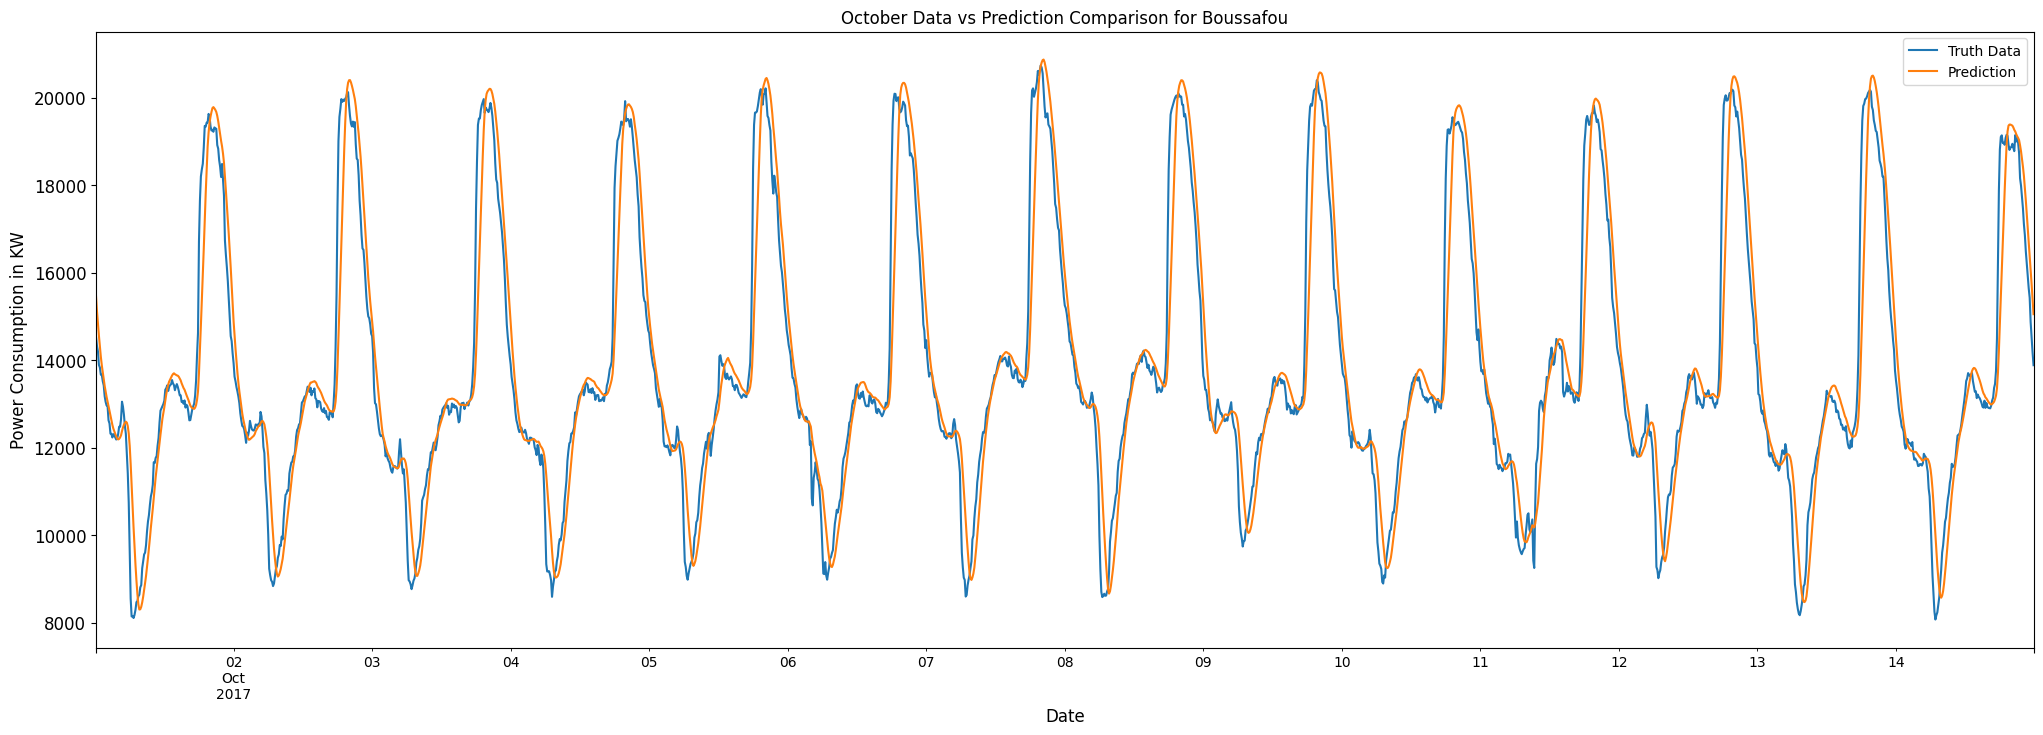

In [ ]:
# Iterate over each zone
for zone in zones:
    # Plot actual data vs predictions for October for the current zone
    ax = df.loc[(df.index > '2017-10-01') & (df.index < '2017-10-15')][[zone, f'prediction_{zone}']] \
        .plot(figsize=(25, 8), title=f'October Data vs Prediction Comparison for {zone}')

    # DEBUG
    # print(df.loc[(df.index > '2017-10-01') & (df.index < '2017-10-15')].head())

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Power Consumption in KW', fontsize=12)
    plt.legend(['Truth Data', 'Prediction'])

    plt.show()


In [ ]:
import json

# Iterate over each zone in ffnn_models
for zone, model in ffnn_models.items():
    # Save model architecture as JSON string
    model_json = model.to_json()
    with open(f'model_architecture_{zone}.json', 'w') as json_file:
        json_file.write(model_json)

    # Save model weights
    model.save_weights(f'model_weights_{zone}.weights.h5')